# Laboratorio 4 - Data Science
## Integrantes:
### Mario Guerra - 21008
### Javier Alvarado - 21188

## Análisis Exploratorio

In [9]:
#!pip install numpy pandas matplotlib seaborn tensorflow scikit-learn

  Using cached scikit_learn-1.5.1-cp311-cp311-win_amd64.whl.metadata (12 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.5.1-cp311-cp311-win_amd64.whl (11.0 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
   ---------------------------------------- 0.0/44.8 MB ? eta -:--:--
   ---------------------------------------- 0.5/44.8 MB 3.4 MB/s eta 0:00:14
   -- ------------------------------------- 2.6/44.8 MB 7.6 MB/s eta 0:00:06
   --- ------------------------------------ 4.5/44.8 MB 7.9 MB/s eta 0:00:06
   ------ --------------------------------- 6.8/44.8 MB 9.1 MB/s eta 0:00:05
   ------- -------------------------------- 8.4/44.8 MB 8.7 MB/s eta 0:00:05
   -------- ------------------------------- 9.4/44.8 MB 7.8 MB/s eta 0:00:05
   --------- ------------------------------ 11.0/44.8 MB 7.9 MB/s eta 0:00:05
   ----------- ---------------------------- 12.6/44.8 MB 7.9 

In [1]:
import pandas as pd
import os
import zipfile
import matplotlib.pyplot as plt
from matplotlib.image import imread
import random
import numpy as np
import seaborn as sns

from os import listdir
import shutil
import numpy as np
import keras.preprocessing.image as kerasImg
import keras.layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import ops

In [3]:
def load_data(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            for file in os.listdir(label_dir):
                file_path = os.path.join(label_dir, file)
                image = load_img(file_path, color_mode='grayscale')
                image = img_to_array(image)
                images.append(image)
                labels.append(label)
    return np.array(images), np.array(labels)

# Cargar datos de entrenamiento y prueba
train_dir = './archive/PolyMNIST/MMNIST/train'
test_dir = './archive/PolyMNIST/MMNIST/test'

train_images, train_labels = load_data(train_dir)
test_images, test_labels = load_data(test_dir)

print(f'Train Images Shape: {train_images.shape}')
print(f'Train Labels Shape: {train_labels.shape}')
print(f'Test Images Shape: {test_images.shape}')
print(f'Test Labels Shape: {test_labels.shape}')


Train Images Shape: (300000, 28, 28, 1)
Train Labels Shape: (300000,)
Test Images Shape: (50000, 28, 28, 1)
Test Labels Shape: (50000,)


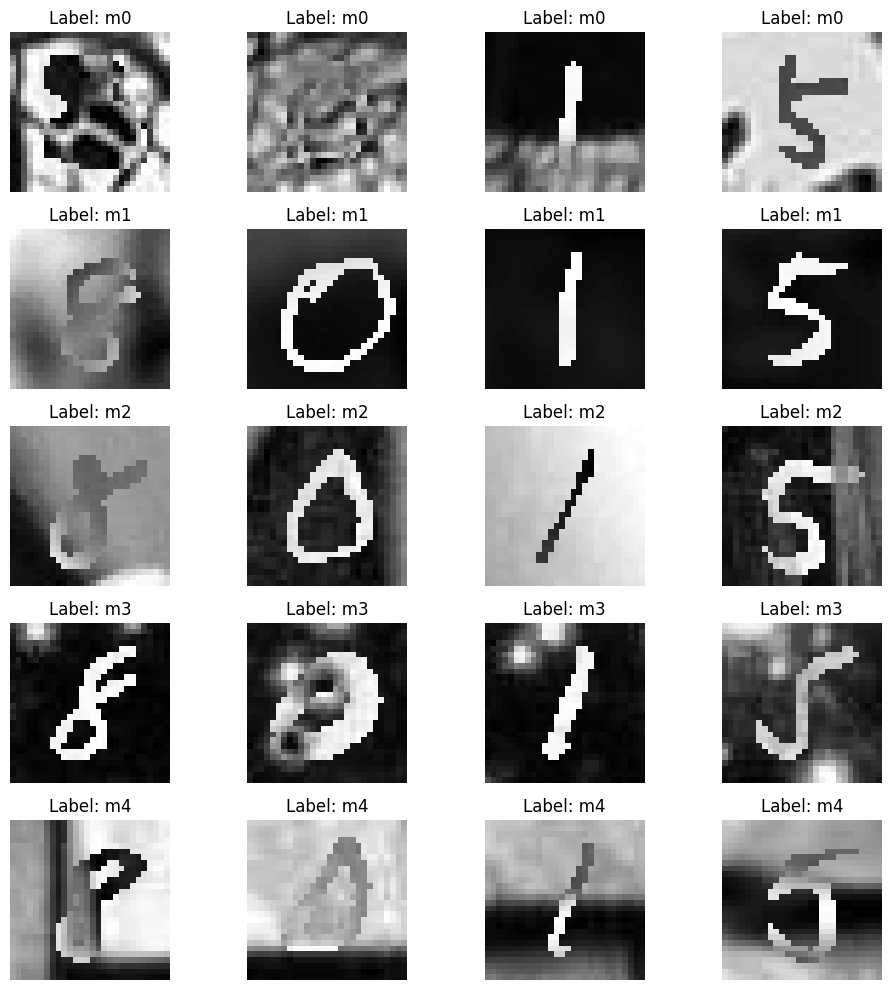

In [4]:
# Convertir etiquetas y datos a un DataFrame para filtrar por cada clase
train_df = pd.DataFrame({'image': list(train_images), 'label': train_labels})

# Mostrar algunas imágenes del dataset de entrenamiento para las etiquetas m1, m2, m3, y m4
plt.figure(figsize=(10, 10))

for i, label in enumerate(['m0', 'm1', 'm2', 'm3', 'm4']):
    # Filtrar imágenes por etiqueta
    filtered_df = train_df[train_df['label'] == label].sample(4, random_state=42)
    
    for j, img in enumerate(filtered_df['image']):
        plt.subplot(5, 4, i * 4 + j + 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f'Label: {label}')
        plt.axis('off')

plt.tight_layout()
plt.show()

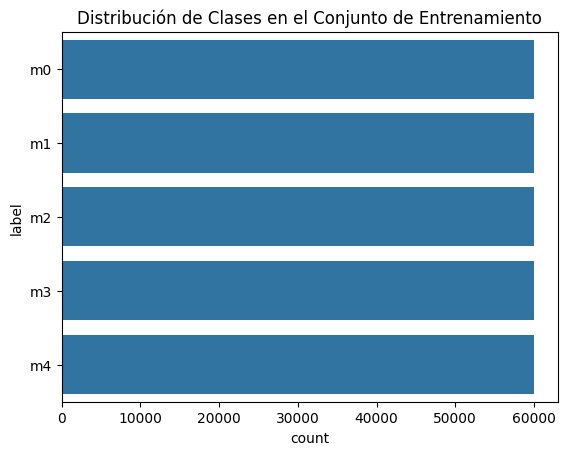

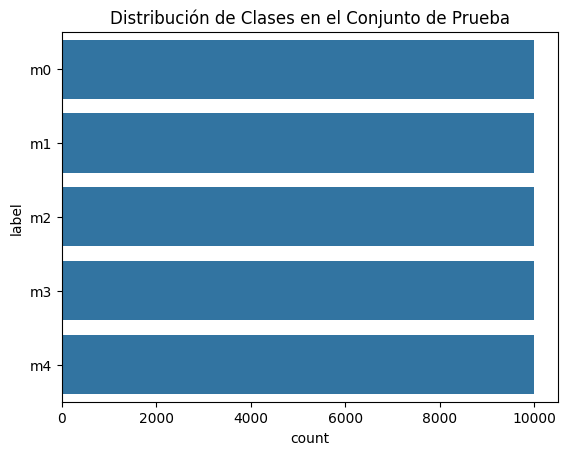

In [5]:
# Convertir etiquetas a DataFrame para facilitar la visualización
train_labels_df = pd.DataFrame(train_labels, columns=['label'])
test_labels_df = pd.DataFrame(test_labels, columns=['label'])

# Visualizar la distribución de las clases
sns.countplot(train_labels_df['label'])
plt.title("Distribución de Clases en el Conjunto de Entrenamiento")
plt.show()

# Visualizar la distribución de las clases
sns.countplot(test_labels_df['label'])
plt.title("Distribución de Clases en el Conjunto de Prueba")
plt.show()


In [6]:
# Verificar la resolución de las imágenes
resolution = train_images[0].shape
print(f'Resolución de las Imágenes: {resolution[0]}x{resolution[1]} píxeles')


Resolución de las Imágenes: 28x28 píxeles


In [7]:
# Contar la cantidad de cada etiqueta
train_class_distribution = train_labels_df['label'].value_counts().to_dict()
test_class_distribution = test_labels_df['label'].value_counts().to_dict()
print(f'Distribución de Clases: {test_class_distribution}')
print(f'Distribución de Clases: {test_class_distribution}')


Distribución de Clases: {'m0': 10000, 'm1': 10000, 'm2': 10000, 'm3': 10000, 'm4': 10000}
Distribución de Clases: {'m0': 10000, 'm1': 10000, 'm2': 10000, 'm3': 10000, 'm4': 10000}


## Creación de modelos de Deep Learning (CNN)

In [8]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Normalizar imágenes
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Codificar etiquetas a números
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Convertir etiquetas a one-hot encoding
train_labels_one_hot = to_categorical(train_labels_encoded)
test_labels_one_hot = to_categorical(test_labels_encoded)


# Modelo 1: CNN Básico

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def create_basic_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(train_images.shape[1], train_images.shape[2], 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

basic_cnn = create_basic_cnn()


c:\Users\Alvar\OneDrive\Documentos\SemestreVIII\Data Science\Lab4DataScience\my\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Modelo 2: CNN Avanzado

In [10]:
from tensorflow.keras.layers import Dropout

def create_advanced_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(train_images.shape[1], train_images.shape[2], 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

advanced_cnn = create_advanced_cnn()

In [11]:
# Entrenamiento del modelo básico
history_basic = basic_cnn.fit(train_images, train_labels_one_hot, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluación del modelo básico
test_loss_basic, test_accuracy_basic = basic_cnn.evaluate(test_images, test_labels_one_hot, verbose=1)
print(f'Accuracy del Modelo Básico: {test_accuracy_basic:.4f}')

# Entrenamiento del modelo avanzado
history_advanced = advanced_cnn.fit(train_images, train_labels_one_hot, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluación del modelo avanzado
test_loss_advanced, test_accuracy_advanced = advanced_cnn.evaluate(test_images, test_labels_one_hot, verbose=1)
print(f'Accuracy del Modelo Avanzado: {test_accuracy_advanced:.4f}')


Epoch 1/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.7892 - loss: 0.4926 - val_accuracy: 0.0000e+00 - val_loss: 17.4422
Epoch 2/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - accuracy: 0.9512 - loss: 0.1330 - val_accuracy: 0.0000e+00 - val_loss: 26.6809
Epoch 3/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.9690 - loss: 0.0870 - val_accuracy: 0.0000e+00 - val_loss: 36.6643
Epoch 4/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.9752 - loss: 0.0694 - val_accuracy: 0.0000e+00 - val_loss: 40.5177
Epoch 5/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.9807 - loss: 0.0551 - val_accuracy: 0.0000e+00 - val_loss: 37.4568
Epoch 6/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.9833 - loss: 0.0475 - val_accuracy: 0.0000e+00 - val_loss: 43.8728
Epoch 7/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.9853 - loss: 0.0417 - val_accuracy: 0.0000e+00 - val_loss: 49.9968
Epoch 8/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 34s 4m

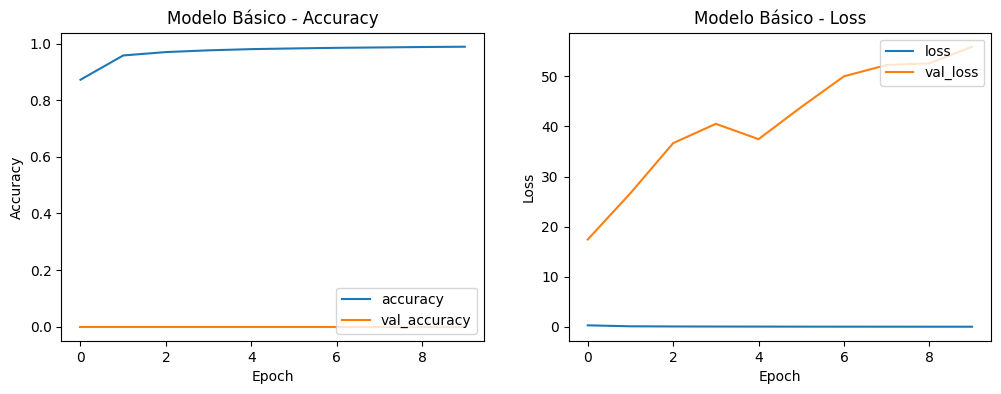

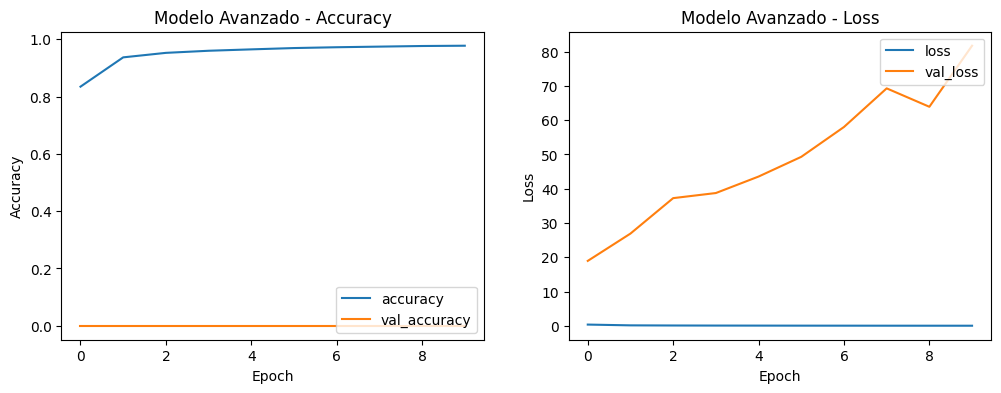

In [12]:
import matplotlib.pyplot as plt

def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    
    plt.show()

plot_history(history_basic, 'Modelo Básico')
plot_history(history_advanced, 'Modelo Avanzado')


# Creación de un modelo de una red neuronal simple

c:\Users\Alvar\OneDrive\Documentos\SemestreVIII\Data Science\Lab4DataScience\my\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.6409 - loss: 0.8014 - val_accuracy: 0.0000e+00 - val_loss: 28.8678
Epoch 2/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.7603 - loss: 0.5436 - val_accuracy: 0.0000e+00 - val_loss: 39.5449
Epoch 3/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.7864 - loss: 0.4899 - val_accuracy: 0.0000e+00 - val_loss: 48.7565
Epoch 4/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 8s 998us/step - accuracy: 0.8034 - loss: 0.4557 - val_accuracy: 0.0000e+00 - val_loss: 51.7910
Epoch 5/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.8144 - loss: 0.4324 - val_accuracy: 0.0000e+00 - val_loss: 52.5349
Epoch 6/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 7s 996us/step - accuracy: 0.8195 - loss: 0.4189 - val_accuracy: 0.0000e+00 - val_loss: 56.2650
Epoch 7/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 8s 1000us/step - accuracy: 0.8274 - loss: 0.4060 - val_accuracy: 0.0000e+00 - val_loss: 52.0260
Epoch 8/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 7s 99

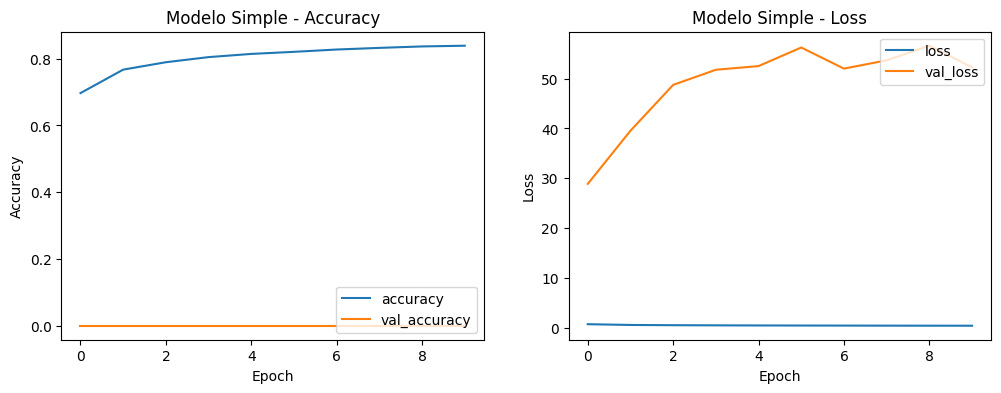

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

def create_simple_nn():
    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Crear y entrenar el modelo de red neuronal simple
simple_nn = create_simple_nn()

# Entrenar el modelo simple
history_simple = simple_nn.fit(train_images, train_labels_one_hot, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluar el modelo simple
test_loss_simple, test_accuracy_simple = simple_nn.evaluate(test_images, test_labels_one_hot, verbose=1)
print(f'Accuracy del Modelo Simple: {test_accuracy_simple:.4f}')

# Graficar los resultados
plot_history(history_simple, 'Modelo Simple')


# Implementación de algoritmo KNN para clasificación de imágenes.

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Aplanar las imágenes para usarlas con KNN (de 28x28 a 784 características)
train_images_flat = train_images.reshape(train_images.shape[0], -1)
test_images_flat = test_images.reshape(test_images.shape[0], -1)

# Crear el modelo KNN
knn_model = KNeighborsClassifier(n_neighbors=3)  # Puedes ajustar el número de vecinos (k)

# Entrenar el modelo KNN
knn_model.fit(train_images_flat, train_labels_encoded)

# Evaluar el modelo KNN
knn_predictions = knn_model.predict(test_images_flat)
knn_accuracy = accuracy_score(test_labels_encoded, knn_predictions)
print(f'Accuracy del Modelo KNN: {knn_accuracy:.4f}')


Accuracy del Modelo KNN: 0.5359


# Transformaciones a los datos (Image Augmentation)

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Crear el generador de datos con augmentación
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False
)

# Re-entrenar el modelo avanzado con augmentación
augmented_train_gen = datagen.flow(train_images, train_labels_one_hot, batch_size=32)

# Re-entrenar el modelo avanzado
history_advanced_augmented = advanced_cnn.fit(augmented_train_gen, 
                                              epochs=10, 
                                              validation_data=(test_images, test_labels_one_hot),
                                              verbose=1)

# Evaluar el modelo avanzado con augmentación
test_loss_advanced_augmented, test_accuracy_advanced_augmented = advanced_cnn.evaluate(test_images, test_labels_one_hot, verbose=1)
print(f'Accuracy del Modelo Avanzado con Augmentación: {test_accuracy_advanced_augmented:.4f}')

Epoch 1/10
  15/9375 ━━━━━━━━━━━━━━━━━━━━ 1:13 8ms/step - accuracy: 0.6144 - loss: 7.5573   

c:\Users\Alvar\OneDrive\Documentos\SemestreVIII\Data Science\Lab4DataScience\my\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9375/9375 ━━━━━━━━━━━━━━━━━━━━ 75s 8ms/step - accuracy: 0.8666 - loss: 0.4248 - val_accuracy: 0.9337 - val_loss: 0.1824
Epoch 2/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 76s 8ms/step - accuracy: 0.9382 - loss: 0.1744 - val_accuracy: 0.9585 - val_loss: 0.1154
Epoch 3/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 76s 8ms/step - accuracy: 0.9449 - loss: 0.1574 - val_accuracy: 0.9547 - val_loss: 0.1199
Epoch 4/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 75s 8ms/step - accuracy: 0.9490 - loss: 0.1463 - val_accuracy: 0.9594 - val_loss: 0.1146
Epoch 5/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 76s 8ms/step - accuracy: 0.9523 - loss: 0.1354 - val_accuracy: 0.9437 - val_loss: 0.1604
Epoch 6/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 76s 8ms/step - accuracy: 0.9540 - loss: 0.1302 - val_accuracy: 0.9614 - val_loss: 0.1046
Epoch 7/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 75s 8ms/step - accuracy: 0.9561 - loss: 0.1268 - val_accuracy: 0.9625 - val_loss: 0.1085
Epoch 8/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 75s 8ms/step - accuracy: 0.9573 - loss: 0.1227 - val

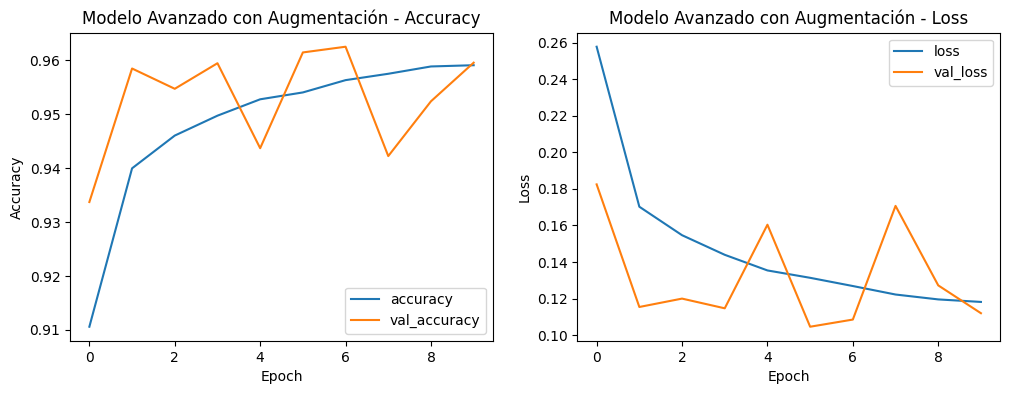

In [17]:
# Graficar los resultados del modelo avanzado con augmentación
plot_history(history_advanced_augmented, 'Modelo Avanzado con Augmentación')

In [36]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def preprocess_image(image_path):
    # Cargar la imagen en escala de grises y redimensionarla a 28x28 píxeles
    image = load_img(image_path, color_mode='grayscale', target_size=(28, 28))
    image = img_to_array(image)
    image = image.astype('float32') / 255.0  # Normalizar
    return np.expand_dims(image, axis=0)  # Agregar la dimensión del batch

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicción: m1


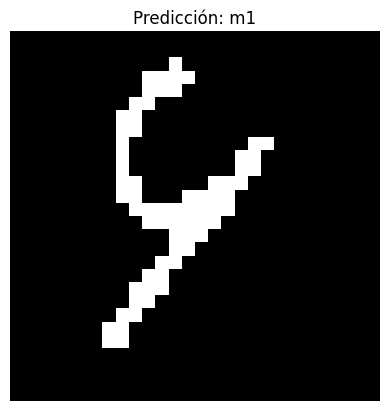

In [46]:
# Ejemplo de cómo cargar y preprocesar una imagen
image_path = './digits/9.1.png'
preprocessed_image = preprocess_image(image_path)

# Realizar una predicción con el modelo avanzado
predictions = advanced_cnn.predict(preprocessed_image)
predicted_class = np.argmax(predictions, axis=1)
predicted_label = label_encoder.inverse_transform(predicted_class)

print(f'Predicción: {predicted_label[0]}')


import matplotlib.pyplot as plt

def display_image(image_path, predicted_label):
    image = load_img(image_path, color_mode='grayscale', target_size=(28, 28))
    plt.imshow(image, cmap='gray')
    plt.title(f'Predicción: {predicted_label}')
    plt.axis('off')
    plt.show()

# Ejemplo de visualización
display_image(image_path, predicted_label[0])


In [48]:
test_loss, test_accuracy = advanced_cnn.evaluate(test_images, test_labels_one_hot, verbose=1)
print(f'Accuracy del Modelo CNN: {test_accuracy:.4f}')
print(f'Loss del Modelo CNN: {test_loss:.4f}')


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9474 - loss: 0.1475
Accuracy del Modelo CNN: 0.9595
Loss del Modelo CNN: 0.1120


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


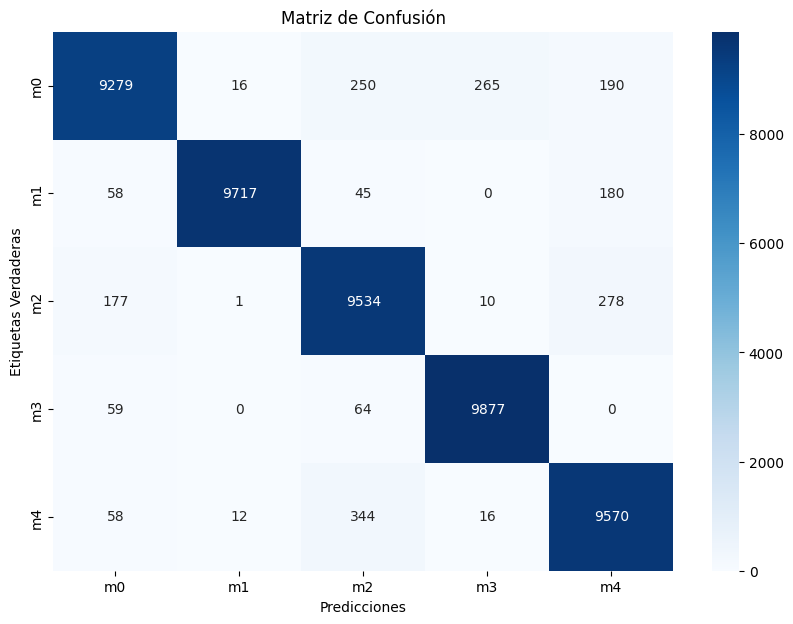

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Obtener predicciones del conjunto de prueba
test_predictions = advanced_cnn.predict(test_images)
test_predictions_classes = np.argmax(test_predictions, axis=1)

# Convertir las etiquetas verdaderas y predicciones en vectores planos
y_true = np.argmax(test_labels_one_hot, axis=1)
cm = confusion_matrix(y_true, test_predictions_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión')
plt.show()
